In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit
from astropy.coordinates import SkyCoord
import astropy.units as u


# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [31]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
#from descriptive_stats import *
#from plots import *

from selection import *
from blazhko_analysis import blazhko_determine, sort3arr, sort4arr, sigG

In [32]:
#| code-fold: false
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

In [33]:
end = 'FINAL_FINAL_FULL'

In [34]:
#| code-fold: false
# DATA from previous notebook
lc_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')

lc_analysis['MainPeakL'] = pd.to_numeric(lc_analysis['MainPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakL'] = pd.to_numeric(lc_analysis['BlazhkoPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodL'] = pd.to_numeric(lc_analysis['BlazhkoPeriodL'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioL'] = pd.to_numeric(lc_analysis['BpowerRatioL'], errors='coerce').fillna(0)
lc_analysis['BsignificanceL'] = pd.to_numeric(lc_analysis['BsignificanceL'], errors='coerce').fillna(0)
lc_analysis['MainPeakZ'] = pd.to_numeric(lc_analysis['MainPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakZ'] = pd.to_numeric(lc_analysis['BlazhkoPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodZ'] = pd.to_numeric(lc_analysis['BlazhkoPeriodZ'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioZ'] = pd.to_numeric(lc_analysis['BpowerRatioZ'], errors='coerce').fillna(0)
lc_analysis['BsignificanceZ'] = pd.to_numeric(lc_analysis['BsignificanceZ'], errors='coerce').fillna(0)

lc_analysis['Pratio'] = round(lc_analysis['Pratio'], 4)
lc_analysis['Plinear'] = round(lc_analysis['Plinear'], 6)
lc_analysis['Pztf'] = round(lc_analysis['Pztf'], 6)
lc_analysis['Lampl'] = round(lc_analysis['Lampl'], 2)
lc_analysis['Zampl'] = round(lc_analysis['Zampl'], 2)
lc_analysis['L_chi2dofR'] = round(lc_analysis['L_chi2dofR'], 1)
lc_analysis['Lmean_chi2dofR'] = round(lc_analysis['Lmean_chi2dofR'], 1)
lc_analysis['Zchi2dofR'] = round(lc_analysis['Zchi2dofR'], 1)
lc_analysis['Zmean_chi2dofR'] = round(lc_analysis['Zmean_chi2dofR'], 1)
lc_analysis['L_chi2dof'] = round(lc_analysis['L_chi2dof'], 1)
lc_analysis['Lmean_chi2dof'] = round(lc_analysis['Lmean_chi2dof'], 1)
lc_analysis['Zchi2dof'] = round(lc_analysis['Zchi2dof'], 1)
lc_analysis['Zmean_chi2dof'] = round(lc_analysis['Zmean_chi2dof'], 1)
lc_analysis['Ampl_diff'] = round(abs(lc_analysis['Lampl'] - lc_analysis['Zampl']), 2)
lc_analysis['dP'] = round(abs((lc_analysis['Plinear']-lc_analysis['Pztf'])/lc_analysis['Pmean']),5)
lc_analysis['MainPeakL'] = round(lc_analysis['MainPeakL'], 4)
lc_analysis['BlazhkoPeakL'] =round(lc_analysis['BlazhkoPeakL'], 4)
lc_analysis['BlazhkoPeriodL'] = round(lc_analysis['BlazhkoPeriodL'], 4)
lc_analysis['BpowerRatioL'] = round(lc_analysis['BpowerRatioL'], 4)
lc_analysis['BsignificanceL'] = round(lc_analysis['BsignificanceL'], 4)
lc_analysis['MainPeakZ'] = round(lc_analysis['MainPeakZ'], 4)
lc_analysis['BlazhkoPeakZ'] = round(lc_analysis['BlazhkoPeakZ'], 4)
lc_analysis['BlazhkoPeriodZ'] = round(lc_analysis['BlazhkoPeriodZ'], 4)
lc_analysis['BpowerRatioZ'] = round(lc_analysis['BpowerRatioZ'], 4)
lc_analysis['BsignificanceZ'] = round(lc_analysis['BsignificanceZ'], 4)
lc_analysis['IndicatorType'] = 'NaN'
lc_analysis['ChiType'] = 'NaN'
lc_analysis['BE_score'] = 'NaN'

periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [35]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557035,0.5570,1.0,301,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0000,1,0.00,0.00003,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.6433,1.0,284,0.105976,0.6,0.7,0.107611,...,1.9161,303.4901,0.0146,2.0748,1,0.10,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530786,0.5308,1.0,276,0.108535,1.1,0.9,0.131104,...,1.0256,42.9553,0.0618,4.7729,1,0.20,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.6747,1.0,177,0.040739,2.8,1.3,0.073285,...,1.5410,16.9635,0.0328,5.4267,1,0.16,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313877,0.3139,1.0,222,0.162522,0.8,0.8,0.865595,...,1.0929,32.3729,0.0969,8.2018,2,0.10,0.00002,NaN,NaN,NaN


In [37]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
end = 'final'
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [38]:
blazhko_can.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,439441,0.709248,0.709248,0.7092,1.0000,349,0.171897,2.1,1.3,0.249301,...,1.4143,227.7904,0.0536,5.3214,1,0.08,0.00000,Z,NaN,NaN
1,664583,0.602994,0.603021,0.6030,1.0000,449,0.115904,1.8,1.1,0.125660,...,1.6618,277.0083,0.0826,9.4402,1,0.16,0.00004,Z,NaN,NaN
2,798477,0.651627,0.651611,0.6516,1.0000,294,0.000000,0.0,0.0,0.000000,...,0.1669,309.1190,143.7553,35.9709,1,0.00,0.00002,Z,NaN,NaN
3,843294,0.374216,0.748404,0.5613,1.9999,290,0.123428,3.3,1.4,0.933846,...,1.3394,314.4654,0.1448,9.3913,2,0.06,0.66665,Z,NaN,NaN
4,880588,0.600138,0.600140,0.6001,1.0000,295,0.110419,3.2,1.2,0.196460,...,1.6691,350.8772,0.1043,15.1599,1,0.20,0.00000,L,NaN,NaN


In [39]:
blazhko_can.shape

(203, 39)

# Creating a visual interface

In [57]:
list(L1.keys())

['modelPhaseGrid',
 'modelFit',
 'dataPhasedTime',
 'A',
 'mmax',
 'modTemplate',
 'dataTemplate',
 'dataTemplateErr',
 'modelFit2data',
 'rms',
 'chi',
 'chi2dof',
 'chi2dofR']

In [75]:
for i in fits:
    L = i[1][2]
    for key in list(L.keys()):  # Iterate over the keys of the dictionary
        if isinstance(L[key], pd.Series):
            L[key] = L[key].to_numpy()

In [111]:
def makeLCplot_info(L1, L2, dataset, order, Lid, plotname='LCplot', plotSave=False):
    '''
    This function plots a single phase of a light curve with fit for both LINEAR and ZTF data, along with 
    a separate box for text data.
    
    Arguments:
        L1: fit data for light curve
    '''
    fig, ax = plt.subplots(1,3, figsize=(32,8))   
    
    fig.suptitle('LINEAR ID:'+str(Lid), fontsize=30)

    ax[0].set(xlabel='data phased with best-fit LINEAR period', ylabel='LINEAR normalized light curve')
    ax[0].set_xlim(-0.1, 1.1)
    ax[0].set_ylim(1.3, -0.3)
    # data
    xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
    ax[0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Plinear
    ax[0].plot(L1['modelPhaseGrid'], L1['modTemplate'], 'red', markeredgecolor='red', lw=1, fillstyle='top', linestyle='dashed')

    ax[1].set(xlabel='data phased with best-fit ZTF period', ylabel='ZTF normalized light curve')
    ax[1].set_xlim(-0.1, 1.1)
    ax[1].set_ylim(1.3, -0.3)
    # data
    xx1, yy1, zz1 = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
    ax[1].errorbar(xx1, yy1, zz1, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
    # fit for Plinear
    ax[1].plot(L2['modelPhaseGrid'], L2['modTemplate'], 'red', markeredgecolor='red', lw=1, fillstyle='top', linestyle='dashed')

    ax[2].axis([0, 8, 0, 10])
    ax[2].text(0, 8, 'LINEAR period chi robust: '+str(dataset['L_chi2dofR'][order])+', LINEAR mean period chi robust: '+str(dataset['Lmean_chi2dofR'][order]),fontsize=15)
    ax[2].text(0, 7, 'ZTF period chi robust: '+str(dataset['Zchi2dofR'][order])+', ZTF mean period chi robust: '+str(dataset['Zmean_chi2dofR'][order]),fontsize=15)
    ax[2].text(0, 6, 'LINEAR period chi: '+str(dataset['L_chi2dof'][order])+', LINEAR mean period chi: '+str(dataset['Lmean_chi2dof'][order]),fontsize=15)
    ax[2].text(0, 5, 'ZTF period chi: '+str(dataset['Zchi2dof'][order])+', ZTF mean period chi: '+str(dataset['Zmean_chi2dof'][order]),fontsize=15)
    ax[2].text(0, 4, 'LINEAR period: '+str(dataset['Plinear'][order])+', ZTF period: '+str(dataset['Pztf'][order])+', Period difference: '+str(dataset['dP'][order]),fontsize=15)
    ax[2].text(0, 3, 'Average LINEAR magnitude: '+str(round(np.mean(data.get_light_curve(Lid).T[1]), 2)),fontsize=15)
    ax[2].text(0, 2, 'LINEAR amplitude:'+str(dataset['Lampl'][order])+', ZTF amplitude:'+str(dataset['Zampl'][order]),fontsize=15)
    ax[2].grid(False)
    ax[2].axis('off')

    
    if plotSave:
        plotName = plotname + '.png'
        plt.savefig(plotName, dpi=600)
    plt.show()     
    return

In [112]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 
        'L_rms', 'L_chi2dof', 'L_chi2dofR', 
        'Lmean_rms', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl', 
        'NdataZTF', 'Z_rms', 'Zchi2dof', 
        'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR', 
        'Zmmax', 'Zampl',
        'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
        'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']

In [113]:
for n, i in enumerate(fits):
    if i[0]==439441:
        print(n)
        break

26


In [114]:
L1 = fits[26][1][0]
L2 = fits[26][1][2]
Lid = blazhko_can['LINEAR id'].to_numpy()[0]

In [115]:
type(L2['dataPhasedTime']), type(L2['dataTemplate']), type(L2['dataTemplateErr'])

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

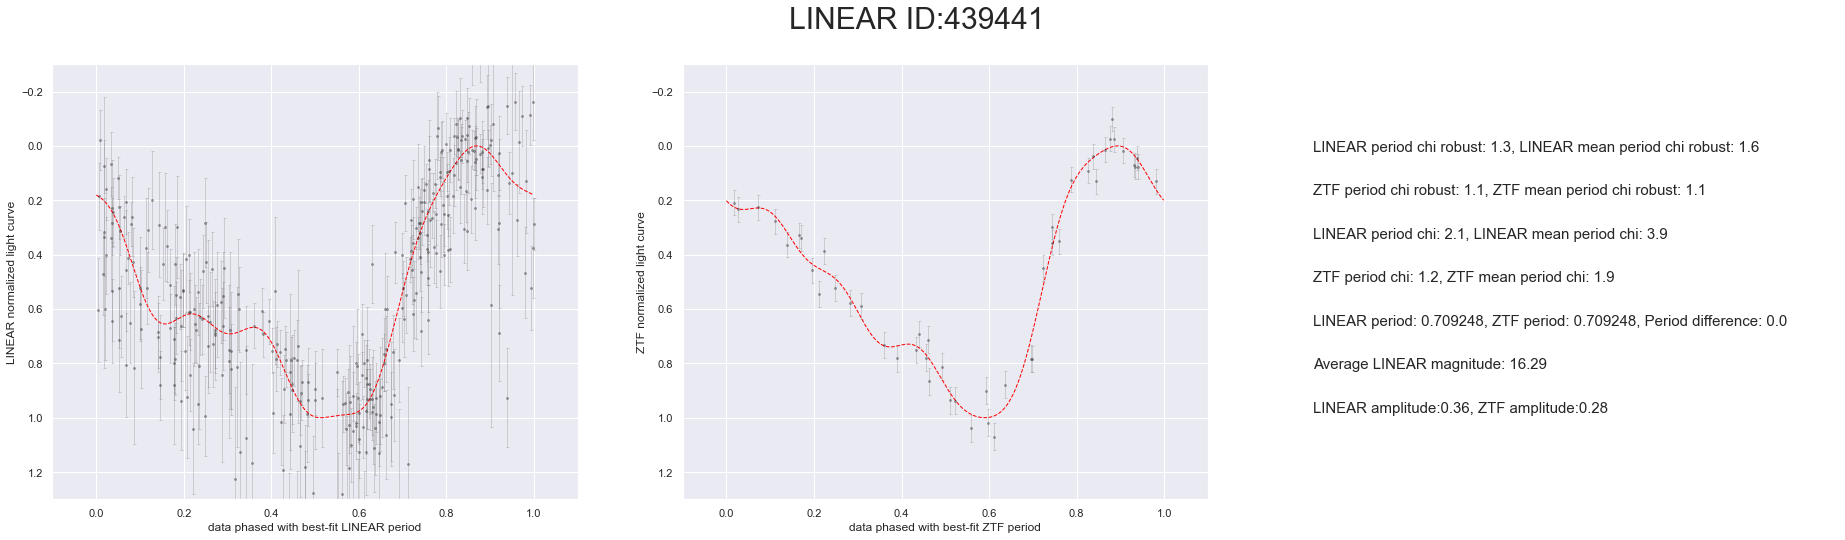

In [116]:
makeLCplot_info(L1, L2, blazhko_can, 0, Lid)

In [ ]:
def makeLCplotBySeason(id0, L1, plotrootname='LCplotBySeason', plotSave=False):
    
    fig = plt.figure(figsize=(10, 12))
    fig.subplots_adjust(hspace=0.2, bottom=0.06, top=0.94, left=0.12, right=0.94)
    
    def plotPanel(ax, L1, season):
        ax.set(xlabel='phase', ylabel='normalized phased light curve')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(1.3, -0.4)
        # fit for Plinear
        ax.plot(L1['modelPhaseGrid'], L1['modTemplate'], 'red', markeredgecolor='red', lw=1, fillstyle='top', linestyle='dashed')
    
        # data
        xx, yy, zz, ww = sort4arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'], L1['obsTimes'])
        tSmin = 52520 + (season-1)*365
        tSmax = 52520 + season*365
        xxS = xx[(ww>tSmin)&(ww<tSmax)]
        yyS = yy[(ww>tSmin)&(ww<tSmax)]
        zzS = zz[(ww>tSmin)&(ww<tSmax)]
        wwS = ww[(ww>tSmin)&(ww<tSmax)]
        ax.errorbar(xxS, yyS, zzS, fmt='.b', ecolor='blue', lw=1, ms=4, capsize=1.5, alpha=0.3)
        textString = "LINEAR season " + str(season)
        ax.text(0.03, 0.96, textString, ha='left', va='top', transform=ax.transAxes)
        textString = "MJD=" + str(tSmin) + ' to ' + str(tSmax)
        ax.text(0.53, 0.96, textString, ha='left', va='top', transform=ax.transAxes)

        
    # plot each season separately 
    for season in range(1,7):
        # plot the power spectrum
        ax = fig.add_subplot(321 + season-1)
        plotPanel(ax, L1, season)
        if (season==1):
            ax.set(title='LINEAR object {0}'.format(id0))

    if plotSave:
        plotName = plotrootname + '.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return

In [58]:
def plotBlazhkoPeaksLINEAR(id0, fL, pL, dataset, fac=1.008, plotSave=False, verbose=True):
    
    print('LINEAR ID=', id0)
    flin = fL[np.argmax(pL)]

    fFolded = dataset['']
    pFolded
    fMainPeak
    fBlazhkoPeak
    BlazhkoPeriod
    BpowerRatio
    Bsignificance

    ## at some point, we will read periodograms back from files...
    fig = plt.figure(figsize=(10, 12))
    fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

    # plot the power spectrum
    ax = fig.add_subplot(321)

    ax.plot(fL, pL, c='b')
    ax.plot([flin, flin], [0,1], lw = 1, c='r', ls='--')
    ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0, 0.7*np.max(pFolded)], lw = 1, c='r', ls='--')
    ax.plot([2*flin-fBlazhkoPeak, 2*flin-fBlazhkoPeak], [0, 0.7*np.max(pFolded)], lw = 1, c='r', ls='--')
    # show 1 year alias
    f1yr = flin+1/365.0
    ax.plot([f1yr, f1yr], [0,0.7*np.max(pFolded)], lw = 1, ls='-.', c='green')
    f1yr = flin-1/365.0
    ax.plot([f1yr, f1yr], [0,0.7*np.max(pFolded)], lw = 1, ls='-.', c='green')

    ax.text(0.03, 0.96, "LINEAR", ha='left', va='top', transform=ax.transAxes)
    if (fBlazhkoPeak > flin*fac):
        ax.set_xlim(0.99*(2*flin-fBlazhkoPeak), 1.01*fBlazhkoPeak)
    else:
        ax.set_xlim(flin/fac, flin*fac)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
    if ymax>1.0: ymax=1.0
    ax.set_ylim(0, ymax)
    ax.set_ylabel('Lomb-Scargle power')
    ax.set_xlabel('frequency (d$^{-1}$)')

    # plot folder power spectrum
    ax = fig.add_subplot(322)

    ax.plot(fFolded, pFolded, c='b')
    ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0,0.4*np.max(pFolded)], lw = 1, ls='--', c='r')
    # show 1 year alias
    f1yr = flin+1/365.0
    ax.plot([f1yr, f1yr], [0,0.4*np.max(pFolded)], lw = 1, ls='-.', c='green')
    
    powerFar = pFolded[fFolded>fBlazhkoPeak]  # frequencies beyond the second peak
    powerFarMedian = np.median(powerFar)      # the median power
    powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
    noise5sig = powerFarMedian+5*powerFarRMS
    
    if (fBlazhkoPeak > flin*fac):
        ax.plot([flin+0.5*(fBlazhkoPeak-flin), 1.01*fBlazhkoPeak], [noise5sig, noise5sig], lw = 1, ls='--', c='cyan')
        ax.set_xlim(flin, 1.01*fBlazhkoPeak)
    else:
        ax.plot([flin+0.5*(fBlazhkoPeak-flin), flin*fac], [noise5sig, noise5sig], lw = 1, ls='--', c='cyan')
        ax.set_xlim(flin, flin*fac)

    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
    if ymax>1.0: ymax=1.0
    ax.set_ylim(0, ymax)
    ax.set_ylabel('folded power')
    ax.set_xlabel('frequency (d$^{-1}$)')

    if plotSave:
        plotName = '../plots/Blazhko.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return fBlazhkoPeak   

In [59]:
def plotLINEARmarkSeasons(id0, LINEARlightcurves):
    tL, mL, mLerr = LINEARlightcurves[id0].T
    fig, ax = plt.subplots()
    ax.errorbar(tL, mL, mLerr, fmt='.b', ecolor='blue')
    ax.set(xlabel='Time (days)', ylabel='LINEAR magnitude', title='LINEAR object {0}'.format(id0))
    ax.invert_yaxis()
    plt.xlim(np.min(tL)-200, np.max(tL)+200)

    for s in range(1, 8):
        tS = 52550 + (s-1)*365
        ax.plot([tS, tS], [np.min(mL)-0.1, np.max(mL)+0.1], c='r')
    plt.show()     
    return


In [61]:
def plotAll(id0, LINEARmetadata, LINEARlightcurves, verbose=True):
    Pcomparison, fL, pL, LINEAR_Plinear = LINEARLS(LINEARmetadata, LINEARlightcurves, id0) 
    fBlazhkoPeak = plotBlazhkoPeaksLINEAR(id0, fL, pL, fac=1.008, plotSave=False, verbose=verbose)
    plotLINEARmarkSeasons(id0, LINEARlightcurves)
    makeLCplotBySeason(id0, LINEAR_Plinear)
    return fL[np.argmax(pL)], fBlazhkoPeak

In [ ]:
ID = blazhko_can['LINEAR id'].to_numpy()[0]

In [ ]:
flin, fBlazhkoPeak = plotAll(ID, Lrrlyr, LINEARlightcurves, verbose=True) 

In [ ]:
class BlazhkoAnalyzer:
    '''
    This class builds a customizable interface for visual inspection of BE candidates.

    INPUTS:
        length(int) = how large is your dataset in length
        data_lc(dataframe) = the dataset we are inspecting
        save_data(dataframe) = where to send BE visual candidates
        ids(list) = list of LINEAR ids
        period(array) = array of periodograms
        fit(array) = array of fits for light curves
    '''

    # initialization of the class
    def __init__(self, length, data_lc, save_data, ids, period, fit):
        # initialize every variable in use for this class
        self.length = length
        self.data_lc = data_lc
        self.save_data = save_data
        self.ids = ids
        self.period = period
        self.fit = fit
        # used for the for loop
        self.current_i = None

        # initialize plotting 
        self.gen = self.plot_light_curves()
        # initalize window for where to show plot
        self.output_plot = widgets.Output()
        
        # Buttons initialization
        self.button_keeping = widgets.Button(description='Keep')
        self.button_continue = widgets.Button(description='Continue')
        
        # Assigning functions to the buttons
        self.button_keeping.on_click(self.on_keep_click)
        self.button_continue.on_click(self.on_continue_click)
        
        # display buttons and plot
        display(self.output_plot, self.button_keeping, self.button_continue)
        
        # starting the for loop
        self.on_continue_click(None)
    
    # DEFINING NECESSARY FUNCTIONS
    # -------
    def plot_light_curves(self):
        '''
        This function plots the light curve data, periodograms and displays important information.
        '''
        for i in range(self.length):
            self.current_i = i # counter for the for loop
            LID = self.ids[i]
            blazhko_analysis(self.data_lc, Lid=LID, order=i, PD=self.period, fits=self.fit, name=str(LID)) # plot
            yield # don't continue until button is pressed

    def on_continue_click(self, b):
        '''
        This button defines what happens when the CONTINUE button is clicked: the program moves
        on to the next light curve.
        '''
        with self.output_plot:
            clear_output(wait=True) # clear the previous output
            try:
                next(self.gen) # generate the next plot and update current_i
            except StopIteration: # when the for loop is finished, disable the button
                print("No more plots.")
                self.button_continue.disabled = True

    def on_keep_click(self, b):
        '''
        This function defines what happens when the KEEP button is clicked: the program
        saves the specific row or light curve information into the save_data dataframe, for later use.
        '''
        row = pd.DataFrame(self.data_lc.iloc[[int(self.current_i)]]) # assign the current row we are analyzing
        # concatenate that row with the save_data dataframe
        self.save_data = pd.concat([self.save_data, row.reset_index(drop=True)], ignore_index=True, axis=0)

    # Saving the save_data dataframe for outside the class
    def get_save_data(self):
        return self.save_data